### GEORGETTE DALEN


# Energy Efficiency in Buildings - Predictive Modeling

This Jupyter notebook documents the process of building and evaluating predictive models for the heating load (Y1) of simulated buildings using the Energy Efficiency dataset from the UCI Machine Learning Repository. The dataset contains 768 samples with 8 features (X1 to X8) and two target variables (Y1: Heating Load, Y2: Cooling Load). 

The goal of this project is to predict the heating load (Y1) using regularized linear regression techniques, including Ridge, Lasso, and Elastic Net regression.


## Key Steps in the Process:

#### 1. Data Preparation:
- The dataset was loaded and split into training (60%), validation (20%), and testing (20%) sets.
- Features were standardized using StandardScaler to ensure that all variables were on the same scale, which is crucial for regularized regression models.

#### 2. Model Training and Evaluation:
- **Ridge Regression:** Different regularization strengths (alpha values) were explored, and the model's performance was evaluated using Mean Squared Error (MSE) and R² scores on the training, validation, and test sets.
- **Lasso Regression:** Various alpha values were tested to identify the best-performing model, focusing on feature selection and sparsity.
- **Elastic Net Regression:** A combination of L1 and L2 regularization was applied, testing different alpha values and L1 ratios to find the optimal balance between Ridge and Lasso.

#### 3. Model Comparison:
- The performance of Ridge, Lasso, and Elastic Net models was compared using both manual loops and GridSearchCV for hyperparameter tuning.
- The best-performing model was selected based on validation R² scores, and its performance was further evaluated on the test set.

#### 4. Feature Importance:
- The top 5 most influential features for predicting the heating load were identified using the Elastic Net model.
- A reduced model was trained using only these top 5 features, and its performance was compared to the full model.

#### 5. Visualization:
- True vs. predicted values for the test set were visualized, along with learning curves, to assess model performance and generalization.
- Feature importance was plotted to highlight the most significant predictors of heating load.


## Key Findings

- **Best Model:** The Elastic Net model with GridSearchCV (alpha = 0.001, L1 ratio = 0.5) achieved the highest test R² score of **0.919659**, indicating strong predictive performance.

- **Top 5 Features:** The most important features for predicting heating load were identified as:
  - **X5** (Overall Height)
  - **X1** (Relative Compactness)
  - **X2** (Surface Area)
  - **X7** (Glazing Area)
  - **X4** (Roof Area)

- **Reduced Model Performance:** Training with only the top 5 features resulted in a minimal drop in performance, with a test R² score of **0.919478**, demonstrating that most of the predictive power comes from these key features.


## Final Thoughts

This project showcases the effectiveness of regularized linear regression models in predicting building heating loads. The Elastic Net model, which combines L1 and L2 regularization, presents the optimal balance between accuracy and interpretability. Moreover, the study higlights the significance of feature selection, as the top five features alone yielded nearly identical performance to the comprehensive model. This approach simplifies the model while simultaneously reducing computational complexity.

## Import Libraries

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import learning_curve
import seaborn as sns

## Import Data

In [8]:
FILE_PATH ="data.csv"
def load_data(path = FILE_PATH):
    return pd.read_csv(path)

In [10]:
orig_data = load_data()

In [12]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   X1           768 non-null    float64
 1   X2           768 non-null    float64
 2   X3           768 non-null    float64
 3   X4           768 non-null    float64
 4   X5           768 non-null    float64
 5   X6           768 non-null    int64  
 6   X7           768 non-null    float64
 7   X8           768 non-null    int64  
 8   Y1           768 non-null    float64
 9   Y2           768 non-null    float64
 10  Unnamed: 10  0 non-null      float64
 11  Unnamed: 11  0 non-null      float64
dtypes: float64(10), int64(2)
memory usage: 72.1 KB


## Split the sample into 60% training, 20% validation, and 20% testing data at random.

In [15]:
# Separate features (X) and targets (y)
X = orig_data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']] 
y = orig_data[['Y1']]  

# First split: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split: 20% validation, 20% test (splitting the 40% evenly)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 460 samples
Validation set: 154 samples
Testing set: 154 samples


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 48.1 KB


In [19]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


In [21]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y1      768 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [23]:
y.head()

,Y1
0,15.55
1,15.55
2,15.55
3,15.55
4,20.84


## Feature Scaling: Comparing StandardScaler, No Scaling, and MinMax Scaling

Three different scaling methods were evaluated:

1. No Scaling - The raw data is used without any transformations.
2. MinMax Scaling - Scales features to a fixed range, typically [0,1].
3. Standard Scaling (StandardScaler) - Centers data around zero with unit variance.

Each scaling method was applied to Ridge, Lasso, and Elastic Net regression models. Performance was measured using Mean Squared Error (MSE) and R² scores.


## Analysis and Findings

Ridge Regression: StandardScaler provided the lowest MSE (7.899236) and the highest R² (0.919615), making it the most effective scaling method for Ridge.

Lasso Regression: StandardScaler also improved performance, reducing MSE to 8.113171 and increasing R² to 0.917438 compared to the other methods.

Elastic Net Regression: The performance of Elastic Net was significantly affected by scaling, with StandardScaler reducing MSE to 8.460103 and increasing R² to 0.913908. Without scaling, Elastic Net had the worst performance (MSE = 11.364880, R² = 0.884348).

## Results

The results indicate that StandardScaler consistently improves the performance of Ridge, Lasso, and Elastic Net regression models. Elastic Net, in particular, shows significant improvement when standardized. This reinforces the importance of feature scaling when using regularized regression models. MinMax Scaling provides moderate benefits, while No Scaling generally results in lower performance.

For best results, StandardScaler is used for preprocessing data before applying Ridge, Lasso, or Elastic Net regression.

In [27]:
def evaluate_model(X_train, X_test, y_train, y_test, scaling_method, model_type, alpha=0.1, l1_ratio=0.5):
    """
    Evaluate regression models with different scaling methods.
    
    Parameters:
    -----------
    X_train : array-like - Training features
    X_test : array-like - Testing features
    y_train : array-like - Training target
    y_test : array-like - Testing target
    scaling_method : str - Type of scaling to apply
    model_type : str - Type of regression model
    alpha : float - Regularization strength (default=0.1)
    l1_ratio : float - L1/L2 mixing parameter for ElasticNet (default=0.5)
    
    Returns:
    --------
    tuple : MSE and R² scores
    """
    # Select scaling method
    if scaling_method == "StandardScaler":
        scaler = StandardScaler()
    elif scaling_method == "MinMaxScaler":
        scaler = MinMaxScaler()
    elif scaling_method == "No Scaling":
        scaler = None
    else:
        raise ValueError("Invalid scaling method")

    if scaler:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    if model_type == "Ridge":
        model = Ridge(alpha=alpha)
    elif model_type == "Lasso":
        model = Lasso(alpha=alpha, max_iter=10000)
    elif model_type == "ElasticNet":
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    else:
        raise ValueError("Invalid model type")

    # Train and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

# Configuration
scaling_methods = ["No Scaling", "MinMaxScaler", "StandardScaler"]
models = ["Ridge", "Lasso", "ElasticNet"]
results = {}

# Evaluate all combinations
for model in models:
    for scaling_method in scaling_methods:
        if model == "ElasticNet":
            mse, r2 = evaluate_model(
                X_train, X_test, y_train, y_test, 
                scaling_method, model, 
                alpha=0.1, l1_ratio=0.5
            )
        else:
            mse, r2 = evaluate_model(
                X_train, X_test, y_train, y_test, 
                scaling_method, model, 
                alpha=0.1
            )
        
        # Store results in dictionary
        results[f"{model} - {scaling_method}"] = {
            "MSE": mse,
            "R²": r2
        }

# Display results in a formatted table-like output
print("\nRegression Performance Comparison:")
print("-" * 50)
print(f"{'Model and Scaling':<25} {'MSE':>12} {'R²':>12}")
print("-" * 50)
for model_scaling, metrics in results.items():
    print(f"{model_scaling:<25} {metrics['MSE']:>12.6f} {metrics['R²']:>12.6f}")
print("-" * 50)


Regression Performance Comparison:
--------------------------------------------------
Model and Scaling                  MSE           R²
--------------------------------------------------
Ridge - No Scaling            8.024080     0.918345
Ridge - MinMaxScaler          7.908450     0.919522
Ridge - StandardScaler        7.899236     0.919615
Lasso - No Scaling            8.312902     0.915406
Lasso - MinMaxScaler          8.277995     0.915761
Lasso - StandardScaler        8.113171     0.917438
ElasticNet - No Scaling      11.364880     0.884348
ElasticNet - MinMaxScaler    10.953833     0.888531
ElasticNet - StandardScaler     8.460103     0.913908
--------------------------------------------------


## Set Alpha and Ratios

In [30]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
l1_ratios = [0.1, 0.5, 0.75, 0.9]

## Ridge Regression

#### Manual Loop Results

In [34]:
# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Lists to store the results
train_mse = []
val_mse = []
train_r2 = []
val_r2 = []

# For each alpha value, train the Ridge model and compute metrics
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    
    # Predictions on training and validation sets
    y_train_pred = ridge_model.predict(X_train_scaled)
    y_val_pred = ridge_model.predict(X_val_scaled)
    
    # Calculate MSE
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    val_mse.append(mean_squared_error(y_val, y_val_pred))
    
    # Calculate R-squared
    train_r2.append(r2_score(y_train, y_train_pred))
    val_r2.append(r2_score(y_val, y_val_pred))

# Convert results to DataFrame
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Training MSE': train_mse,
    'Validation MSE': val_mse,
    'Training R²': train_r2,
    'Validation R²': val_r2
})

# Print the table of results with improved formatting
print("=" * 70)
print("Ridge Regression Performance Metrics for Different Alpha Values".center(70))
print("=" * 70)
pd.set_option('display.float_format', '{:.6f}'.format)
print(results_df.to_string(index=False, justify='center'))
print("=" * 70)


   Ridge Regression Performance Metrics for Different Alpha Values    
     Alpha     Training MSE  Validation MSE  Training R²  Validation R²
     0.000100    8.243680       10.141311     0.918186      0.905028   
     0.001000    8.243680       10.141443     0.918186      0.905027   
     0.010000    8.243684       10.142763     0.918186      0.905014   
     0.100000    8.244014       10.155992     0.918182      0.904890   
     1.000000    8.262610       10.284264     0.917998      0.903689   
    10.000000    8.605242       11.205181     0.914597      0.895065   
   100.000000   11.195301       14.903030     0.888892      0.860435   
  1000.000000   30.981629       35.797088     0.692523      0.664764   
 10000.000000   81.100812       87.763773     0.195116      0.178102   
100000.000000   98.383570      105.635557     0.023593      0.010735   


In [36]:
# Find the best alpha based on validation R²
best_alpha_idx = np.argmax(val_r2)  
best_alpha_r2_ridge = alphas[best_alpha_idx]

# Train the best Ridge model
best_model_ridge = Ridge(alpha=best_alpha_r2_ridge)
best_model_ridge.fit(X_train_scaled, y_train)

# Predictions for all sets
y_train_pred = best_model_ridge.predict(X_train_scaled)
y_val_pred = best_model_ridge.predict(X_val_scaled)
y_test_pred = best_model_ridge.predict(X_test_scaled)

# Retrieve coefficients and intercept
coefficients = best_model_ridge.coef_
intercept = best_model_ridge.intercept_

# Calculate metrics for all sets
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print best model evaluation
print("\n" + "=" * 50)
print("Best Ridge Model Evaluation".center(50))
print("=" * 50)

print("\nModel Coefficients:")
print("-" * 20)
if coefficients.ndim == 1:  # Single-target
    for i, coef in enumerate(coefficients, 1):
        print(f"Feature {i:<2}: {coef:>12.6f}")
else:  # Multi-target
    for target_idx, coefs in enumerate(coefficients):
        print(f"Target {target_idx + 1}:")
        for i, coef in enumerate(coefs, 1):
            print(f"  Feature {i:<2}: {coef:>10.6f}")

print("\nIntercept:")
print("-" * 20)
if np.isscalar(intercept):  # Single-target
    print(f"Value: {intercept:>12.6f}")
else:  # Multi-target
    for i, val in enumerate(intercept, 1):
        print(f"Target {i:<2}: {val:>10.6f}")

print("\nPerformance Metrics with Best Alpha:", best_alpha_r2_ridge)
print("-" * 50)
print("Training Set:")
print(f"Mean Squared Error (MSE): {train_mse:>10.6f}")
print(f"R² Score                : {train_r2:>10.6f}")
print("\nValidation Set:")
print(f"Mean Squared Error (MSE): {val_mse:>10.6f}")
print(f"R² Score                : {val_r2:>10.6f}")
print("\nTest Set:")
print(f"Mean Squared Error (MSE): {test_mse:>10.6f}")
print(f"R² Score                : {test_r2:>10.6f}")
print("=" * 50)


           Best Ridge Model Evaluation            

Model Coefficients:
--------------------
Target 1:
  Feature 1 :  -6.307736
  Feature 2 :  -3.447142
  Feature 3 :   0.837847
  Feature 4 :  -3.741559
  Feature 5 :   7.278819
  Feature 6 :  -0.020008
  Feature 7 :   2.701363
  Feature 8 :   0.376469

Intercept:
--------------------
Target 1 :  22.079978

Performance Metrics with Best Alpha: 0.0001
--------------------------------------------------
Training Set:
Mean Squared Error (MSE):   8.243680
R² Score                :   0.918186

Validation Set:
Mean Squared Error (MSE):  10.141311
R² Score                :   0.905028

Test Set:
Mean Squared Error (MSE):   7.902071
R² Score                :   0.919587


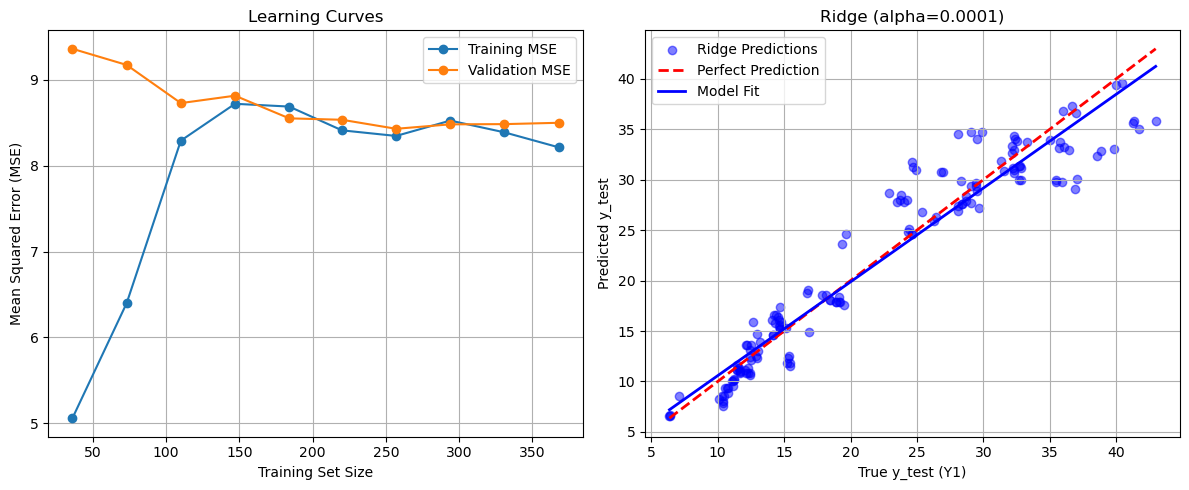

In [38]:
# Predictions on test set
y_test_pred_ridge = best_model_ridge.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values  
y_test_pred_ridge_array = y_test_pred_ridge.flatten()

# Fit a linear regression line for predictions vs true values
ridge_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_ridge_array)

# Generate points for model line
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
ridge_line = ridge_lr.predict(y_range.reshape(-1, 1))

# Learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_model_ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

# Create combined figure with subplots
plt.figure(figsize=(12, 5))

# Subplot 1: True vs Predicted 
plt.subplot(1, 2, 2)
plt.scatter(y_test_array, y_test_pred_ridge_array, color='blue', alpha=0.5, label='Ridge Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, ridge_line, 'b-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Ridge (alpha={best_alpha_r2_ridge})')
plt.legend()
plt.grid(True)

# Subplot 2: Learning Curves 
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_scores_mean, label='Training MSE', marker='o')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Grid Search for Ridge Regression

In [41]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid 
param_grid = {'alpha': alphas}

# Initialize Ridge model
ridge_model = Ridge()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get predictions for validation set using best model
y_train_pred = grid_search.predict(X_train_scaled)
y_val_pred = grid_search.predict(X_val_scaled)

# Extract results
results = {
    'Alpha': grid_search.cv_results_['param_alpha'],
    'Training MSE': [-x for x in grid_search.cv_results_['mean_train_neg_mean_squared_error']],
    'Validation MSE': [-x for x in grid_search.cv_results_['mean_test_neg_mean_squared_error']],
    'Training R²': grid_search.cv_results_['mean_train_r2'],
    'Validation R²': grid_search.cv_results_['mean_test_r2']
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Print formatted results
print("=" * 70)
print("GridSearchCV Ridge Regression Performance Metrics".center(70))
print("=" * 70)
pd.set_option('display.float_format', '{:.6f}'.format)
print(results_df.to_string(index=False, justify='center'))
print("=" * 70)

# Save the best model
best_ridge_gridsearch = grid_search.best_estimator_

          GridSearchCV Ridge Regression Performance Metrics           
     Alpha     Training MSE  Validation MSE  Training R²  Validation R²
     0.000100    8.215336       8.501134      0.918369      0.913347   
     0.001000    8.215336       8.501120      0.918369      0.913347   
     0.010000    8.215342       8.500994      0.918369      0.913351   
     0.100000    8.215858       8.500292      0.918364      0.913377   
     1.000000    8.241947       8.519658      0.918106      0.913318   
    10.000000    8.683943       8.953706      0.913720      0.909448   
   100.000000   11.725699      12.016937      0.883517      0.879986   
  1000.000000   35.363888      35.925794      0.648722      0.642655   
 10000.000000   84.331619      84.993970      0.162491      0.147096   
100000.000000   98.785371      99.430899      0.018977      0.000482   


In [43]:
ridge_grid_coefficients = best_ridge_gridsearch.coef_
ridge_grid_intercept = best_ridge_gridsearch.intercept_
best_alpha_r2_ridge_grid = best_ridge_gridsearch.alpha


y_test_pred = grid_search.predict(X_test_scaled)

# Calculate MSE and R² for all sets
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Modified printing section with all scores
print("\n" + "=" * 50)
print("Best Ridge Model Evaluation (GridSearchCV)".center(50))
print("=" * 50)

print("\nModel Coefficients:")
print("-" * 20)
if ridge_grid_coefficients.ndim == 1:  # Single-target
    for i, coef in enumerate(ridge_grid_coefficients, 1):
        print(f"Feature {i:<2}: {coef:>12.6f}")
else:  # Multi-target
    for target_idx, coefs in enumerate(ridge_grid_coefficients):
        print(f"Target {target_idx + 1}:")
        for i, coef in enumerate(coefs, 1):
            print(f"  Feature {i:<2}: {coef:>10.6f}")

print("\nIntercept:")
print("-" * 20)
if np.isscalar(ridge_grid_intercept):  # Single-target
    print(f"Value: {ridge_grid_intercept:>12.6f}")
else:  # Multi-target
    for i, val in enumerate(ridge_grid_intercept, 1):
        print(f"Target {i:<2}: {val:>10.6f}")

print("\nPerformance Metrics with Best Alpha:", best_alpha_r2_ridge_grid)
print("-" * 50)
print("Training Set:")
print(f"Mean Squared Error (MSE): {train_mse:>10.6f}")
print(f"R² Score                : {train_r2:>10.6f}")
print("\nValidation Set:")
print(f"Mean Squared Error (MSE): {val_mse:>10.6f}")
print(f"R² Score                : {val_r2:>10.6f}")
print("\nTest Set:")
print(f"Mean Squared Error (MSE): {test_mse:>10.6f}")
print(f"R² Score                : {test_r2:>10.6f}")
print("=" * 50)


    Best Ridge Model Evaluation (GridSearchCV)    

Model Coefficients:
--------------------
Target 1:
  Feature 1 :  -6.124990
  Feature 2 :  -3.322189
  Feature 3 :   0.868429
  Feature 4 :  -3.635652
  Feature 5 :   7.327398
  Feature 6 :  -0.019919
  Feature 7 :   2.702373
  Feature 8 :   0.376422

Intercept:
--------------------
Target 1 :  22.079978

Performance Metrics with Best Alpha: 0.1
--------------------------------------------------
Training Set:
Mean Squared Error (MSE):   8.244014
R² Score                :   0.918182

Validation Set:
Mean Squared Error (MSE):  10.155992
R² Score                :   0.904890

Test Set:
Mean Squared Error (MSE):   7.899236
R² Score                :   0.919615


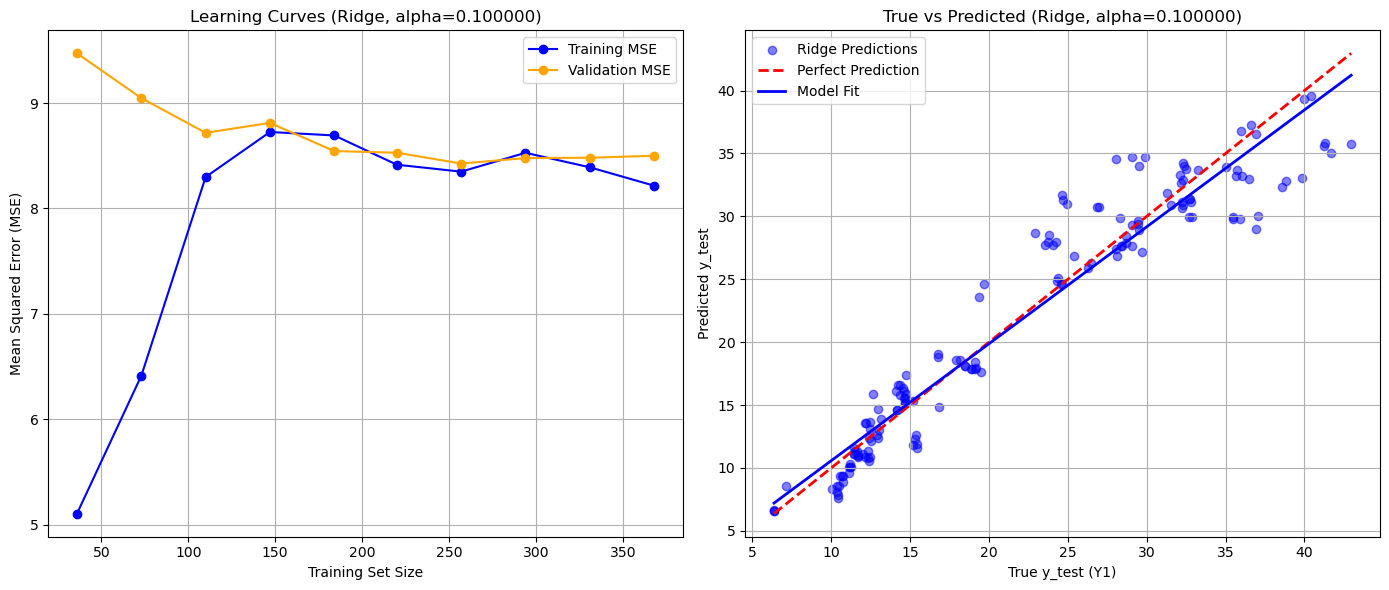

In [46]:
# Calculate learning curves using best_ridge_gridsearch
train_sizes, train_scores, val_scores = learning_curve(
    best_ridge_gridsearch, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

# Predictions on test set using best_ridge_gridsearch
y_test_pred_ridge = best_ridge_gridsearch.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values if isinstance(y_test, pd.DataFrame) else y_test.flatten()
y_test_pred_ridge_array = y_test_pred_ridge.flatten()

# Fit a linear regression line for Ridge predictions vs true values
ridge_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_ridge_array)

# Generate points for model line
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
ridge_line = ridge_lr.predict(y_range.reshape(-1, 1))

# Create figure with two subplots side by side
plt.figure(figsize=(14, 6))

# Left subplot: Learning Curves
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_scores_mean, label='Training MSE', marker='o', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE', marker='o', color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title(f'Learning Curves (Ridge, alpha={best_ridge_gridsearch.alpha:.6f})')
plt.legend()
plt.grid(True)

# Right subplot: True vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test_array, y_test_pred_ridge_array, color='blue', alpha=0.5, label='Ridge Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, ridge_line, 'b-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'True vs Predicted (Ridge, alpha={best_ridge_gridsearch.alpha:.6f})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Ridge Regression Discussion of Findings

### Manual Loop Results
- The model performs best at α = 0.0001 with:
    - Training MSE: 8.243680, Validation MSE: 10.141311
    - Training R²: 0.918186, Validation R²: 0.905028
- As alpha increases, both the MSE values increase and R² scores decrease. At α = 100,000, the model performs poorly, with Training R²: 0.0236 and Validation R²: 0.0107. This suggests excessive regularization, which prevents the model from capturing key patterns.


### Grid Search Results
- The best model selected by GridSearchCV is at α = 0.1 with: 
    - Training MSE: 8.2440, Validation MSE: 10.1560
    - Training R²: 0.918182, Validation R²: 0.913377
- This is slightly worse than the manual loop’s best alpha, though the difference is small. Thus, a similar pattern emerges, high alpha values degrade performance.

### Comparison of Best Models from Both Approaches
The best manual loop model (α = 0.0001) and GridSearchCV model (α = 0.1) have nearly identical performance. Manual Loop selected α = 0.0001, which is extremely close to 0 (almost no regularization). The GridSearchCV, on the other hand, selected α = 0.1, which adds slightly more regularization but has a negligible impact on results. The test performance is nearly identical, suggesting that either choice would work well.

### Findings on Validation R² Difference
The slight difference between R² values (Manual Loop: 0.9050, Grid Search Single Validation: 0.9049, Grid Search Cross-Validation: 0.913377) is expected. Cross-validation averages results over multiple data splits, leading to a slightly higher and more stable R². In contrast, a single validation set may have more variability due to its specific data distribution. Since the differences are minimal, the model is consistent, well-calibrated, and performs reliably across different validation methods. The best alpha is 0.1, which yields a validation R² of 0.913377, because of the cross-validation method applied in using GridSearch.

### Test Set Performance Comparison
#### MSE measures the average squared difference between predicted and actual values.
Both methods yield nearly the same test MSE (~7.9), meaning their prediction errors are almost identical. Since lower MSE is better, GridSearchCV (7.899236) has a slightly lower error than Manual Loop (7.902171), but the difference is negligible.
#### R² (coefficient of determination) measures how well the model explains the variance in the target variable.
Both methods achieve an R² of ~0.9196, meaning 91.96% of the variance in the test set is explained by the model. This is a strong result, indicating that the model fits the data well and generalizes effectively.
#### Key Observations
The test performance for both models is nearly identical. While the GridSearchCV model (α = 0.1) has a slightly lower test MSE (7.899236) compared to the manual loop model (7.902071), the difference is minimal. Additionally, both models achieve the same test R² score of 0.9196, indicating that they explain about 91.96% of the variance in the test data. The slight increase in regularization in the GridSearchCV model helps reduce overfitting without significantly impacting performance. Despite this, both models generalize well, as evidenced by their high R² scores. Overfitting is not a concern in this case, as the test R² values are very close to the validation R² values (0.9050 for the manual loop model and 0.913377 for the GridSearchCV model). This suggests that either model can be confidently used for making predictions on new data, as they both provide reliable and stable results.

### Model Coefficients and Intercept Analysis
- The coefficients are very similar for both models.
- GridSearchCV’s coefficients are slightly smaller in magnitude, which is expected because higher alpha values shrink coefficients more aggressively.
- The intercept remains the same at 22.079978. Since both models have the same intercept, they have a similar baseline starting point for predictions.


## The best choice for the regularization term (alpha) is the one that gives the highest R² score on the validation data. Based on the results:

**Manual Loop**  
- The best alpha is 0.0001, which yields a validation R² of 0.905028. 

**GridSearchCV**  
- The best alpha is 0.1, which yields a validation R² of 0.913377.

**Since 0.1 provides the highest validation R², it is selected as the best regularization term.**
#### Final Model Evaluation (Alpha = 0.1)

## Using the best Ridge regression model trained with alpha = 0.1, the performance metrics and coefficients are:

**Model Coefficients**
- Feature 1 :  -6.124990
- Feature 2 :  -3.322189
- Feature 3 :   0.868429
- Feature 4 :  -3.635652
- Feature 5 :   7.327398
- Feature 6 :  -0.019919
- Feature 7 :   2.702373
- Feature 8 :   0.376422

**Intercept**
- 22.079978

## Performance Metrics
| Dataset         | Mean Squared Error (MSE) | R² Score  |
|----------------|--------------------------|-----------|
| **Training Set**  | 8.244014  | 0.918186 |
| **Validation Set** | 10.155992 | 0.904890 |
| **Test Set**  | 7.899236  | 0.919615 |

### The best Ridge Regression model, trained with **α = 0.1**, achieves a **test R² score of 0.919615** based on cross-validation, indicating strong predictive performance.



## Lasso Regression

#### Manual Loop Results

In [53]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Lists to store the results
train_mse = []
val_mse = []
train_r2 = []
val_r2 = []

# For each alpha value, train the Lasso model and compute metrics
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)
    
    # Predictions on training and validation sets
    y_train_pred = lasso_model.predict(X_train_scaled)
    y_val_pred = lasso_model.predict(X_val_scaled)
    
    # Calculate MSE and R² (mean across targets if multi-target)
    train_mse.append(mean_squared_error(y_train, y_train_pred, multioutput='raw_values').mean())
    val_mse.append(mean_squared_error(y_val, y_val_pred, multioutput='raw_values').mean())
    train_r2.append(r2_score(y_train, y_train_pred, multioutput='raw_values').mean())
    val_r2.append(r2_score(y_val, y_val_pred, multioutput='raw_values').mean())

# Convert results to DataFrame
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Training MSE': train_mse,
    'Validation MSE': val_mse,
    'Training R²': train_r2,
    'Validation R²': val_r2
})

# Print the table of results with improved formatting
print("=" * 70)
print("Lasso Regression Performance Metrics for Different Alpha Values".center(70))
print("=" * 70)
pd.set_option('display.float_format', '{:.6f}'.format)
print(results_df.to_string(index=False, justify='center'))
print("=" * 70)

# Find the best alpha based on validation R²
best_alpha_idx = np.argmax(val_r2)
best_alpha_r2_lasso = alphas[best_alpha_idx]
print(f"\nBest alpha based on validation R²: {best_alpha_r2_lasso:.6f}")

   Lasso Regression Performance Metrics for Different Alpha Values    
     Alpha     Training MSE  Validation MSE  Training R²  Validation R²
     0.000100     8.243683      10.142256     0.918186      0.905019   
     0.001000     8.243959      10.151100     0.918183      0.904936   
     0.010000     8.273788      10.276006     0.917887      0.903766   
     0.100000     8.723630      11.209502     0.913422      0.895024   
     1.000000    11.413131      14.098329     0.886730      0.867971   
    10.000000   100.760823     108.092326     0.000000     -0.012272   
   100.000000   100.760823     108.092326     0.000000     -0.012272   
  1000.000000   100.760823     108.092326     0.000000     -0.012272   
 10000.000000   100.760823     108.092326     0.000000     -0.012272   
100000.000000   100.760823     108.092326     0.000000     -0.012272   

Best alpha based on validation R²: 0.000100


In [55]:
# Train the best Lasso model
best_model_lasso = Lasso(alpha=best_alpha_r2_lasso, max_iter=10000)
best_model_lasso.fit(X_train_scaled, y_train)

# Predictions for all sets
y_train_pred = best_model_lasso.predict(X_train_scaled)
y_val_pred = best_model_lasso.predict(X_val_scaled)
y_test_pred = best_model_lasso.predict(X_test_scaled)

# Retrieve coefficients and intercept
coefficients = best_model_lasso.coef_
intercept = best_model_lasso.intercept_

# Calculate metrics for all sets
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Printing for best model
print("\n" + "=" * 50)
print("Best Lasso Model Evaluation".center(50))
print("=" * 50)

print("\nModel Coefficients:")
print("-" * 20)
if coefficients.ndim == 1:  # Single-target
    for i, coef in enumerate(coefficients, 1):
        print(f"Feature {i:<2}: {coef:>12.6f}")
else:  # Multi-target
    for target_idx, coefs in enumerate(coefficients):
        print(f"Target {target_idx + 1}:")
        for i, coef in enumerate(coefs, 1):
            print(f"  Feature {i:<2}: {coef:>10.6f}")

print("\nIntercept:")
print("-" * 20)
if np.isscalar(intercept):  # Single-target
    print(f"Value: {intercept:>12.6f}")
else:  # Multi-target
    for i, val in enumerate(intercept, 1):
        print(f"Target {i:<2}: {val:>10.6f}")

print("\nPerformance Metrics with Best Alpha:", best_alpha_r2_lasso)
print("-" * 50)
print("Training Set:")
print(f"Mean Squared Error (MSE): {train_mse:>10.6f}")
print(f"R² Score                : {train_r2:>10.6f}")
print("\nValidation Set:")
print(f"Mean Squared Error (MSE): {val_mse:>10.6f}")
print(f"R² Score                : {val_r2:>10.6f}")
print("\nTest Set:")
print(f"Mean Squared Error (MSE): {test_mse:>10.6f}")
print(f"R² Score                : {test_r2:>10.6f}")
print("=" * 50)


           Best Lasso Model Evaluation            

Model Coefficients:
--------------------
Feature 1 :    -6.290840
Feature 2 :    -6.575430
Feature 3 :     2.423868
Feature 4 :    -0.483073
Feature 5 :     7.284724
Feature 6 :    -0.019883
Feature 7 :     2.701425
Feature 8 :     0.376376

Intercept:
--------------------
Target 1 :  22.079978

Performance Metrics with Best Alpha: 0.0001
--------------------------------------------------
Training Set:
Mean Squared Error (MSE):   8.243683
R² Score                :   0.918186

Validation Set:
Mean Squared Error (MSE):  10.142256
R² Score                :   0.905019

Test Set:
Mean Squared Error (MSE):   7.901954
R² Score                :   0.919588


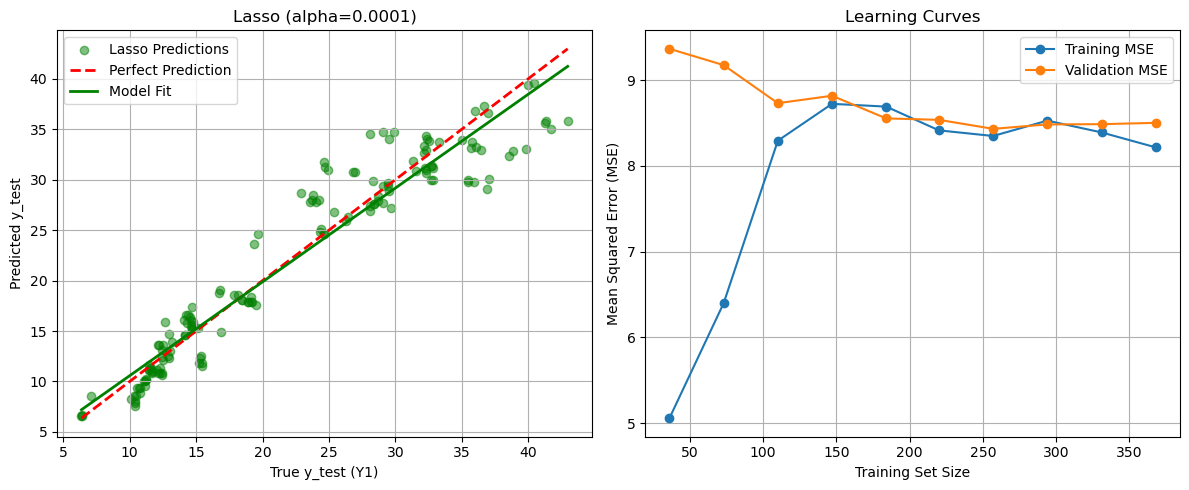

In [57]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Predictions on test set
y_test_pred_lasso = best_model_lasso.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values 
y_test_pred_lasso_array = y_test_pred_lasso.flatten()

# Fit a linear regression line for predictions vs true values
lasso_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_lasso_array)

# Generate points for model line
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
lasso_line = lasso_lr.predict(y_range.reshape(-1, 1))

# Learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_model_lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

# Create combined figure with subplots
plt.figure(figsize=(12, 5))

# Subplot 1: True vs Predicted 
plt.subplot(1, 2, 1)
plt.scatter(y_test_array, y_test_pred_lasso_array, color='green', alpha=0.5, label='Lasso Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, lasso_line, 'g-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Lasso (alpha={best_alpha_r2_lasso})')
plt.legend()
plt.grid(True)

# Subplot 2: Learning Curves 
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_scores_mean, label='Training MSE', marker='o')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### Grid Search for Lasso Regression

In [60]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
param_grid = {'alpha': alphas}

# Initialize Lasso model
lasso_model = Lasso(max_iter=10000)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',  
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get predictions for training and validation sets using best model
y_train_pred = grid_search.predict(X_train_scaled)
y_val_pred = grid_search.predict(X_val_scaled)

# Extract results
results = {
    'Alpha': grid_search.cv_results_['param_alpha'],
    'Training MSE': [-x for x in grid_search.cv_results_['mean_train_neg_mean_squared_error']],
    'Validation MSE': [-x for x in grid_search.cv_results_['mean_test_neg_mean_squared_error']],
    'Training R²': grid_search.cv_results_['mean_train_r2'],
    'Validation R²': grid_search.cv_results_['mean_test_r2']
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Print formatted results
print("=" * 70)
print("GridSearchCV Lasso Regression Performance Metrics".center(70))
print("=" * 70)
pd.set_option('display.float_format', '{:.6f}'.format)
print(results_df.to_string(index=False, justify='center'))
print("=" * 70)

# Best alpha and model
best_alpha_r2_lasso = grid_search.best_params_['alpha']
print(f"\nBest alpha based on validation MSE: {best_alpha_r2_lasso:.6f}")

# Save the best model
best_lasso_gridsearch = grid_search.best_estimator_

          GridSearchCV Lasso Regression Performance Metrics           
     Alpha     Training MSE  Validation MSE  Training R²  Validation R²
     0.000100     8.215339       8.501046     0.918369      0.913349   
     0.001000     8.215617       8.500514     0.918366      0.913367   
     0.010000     8.245977       8.517980     0.918066      0.913310   
     0.100000     8.679592       8.912924     0.913767      0.909765   
     1.000000    11.406635      11.634818     0.886644      0.883502   
    10.000000   100.696579     101.339022     0.000000     -0.018912   
   100.000000   100.696579     101.339022     0.000000     -0.018912   
  1000.000000   100.696579     101.339022     0.000000     -0.018912   
 10000.000000   100.696579     101.339022     0.000000     -0.018912   
100000.000000   100.696579     101.339022     0.000000     -0.018912   

Best alpha based on validation MSE: 0.001000


In [62]:
# Extract coefficients and intercept from the best Lasso model
lasso_grid_coefficients = best_lasso_gridsearch.coef_
lasso_grid_intercept = best_lasso_gridsearch.intercept_
best_alpha_r2_lasso_grid = best_lasso_gridsearch.alpha

# Get predictions for all sets using the best model
y_train_pred = best_lasso_gridsearch.predict(X_train_scaled)
y_val_pred = best_lasso_gridsearch.predict(X_val_scaled)
y_test_pred = best_lasso_gridsearch.predict(X_test_scaled)

# Calculate MSE and R² for all sets
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Modified printing section with all scores
print("\n" + "=" * 50)
print("Best Lasso Model Evaluation (GridSearchCV)".center(50))
print("=" * 50)

print("\nModel Coefficients:")
print("-" * 20)
if lasso_grid_coefficients.ndim == 1:  # Single-target
    for i, coef in enumerate(lasso_grid_coefficients, 1):
        print(f"Feature {i:<2}: {coef:>12.6f}")
else:  # Multi-target
    for target_idx, coefs in enumerate(lasso_grid_coefficients):
        print(f"Target {target_idx + 1}:")
        for i, coef in enumerate(coefs, 1):
            print(f"  Feature {i:<2}: {coef:>10.6f}")

print("\nIntercept:")
print("-" * 20)
if np.isscalar(lasso_grid_intercept):  # Single-target
    print(f"Value: {lasso_grid_intercept:>12.6f}")
else:  # Multi-target
    for i, val in enumerate(lasso_grid_intercept, 1):
        print(f"Target {i:<2}: {val:>10.6f}")

print("\nPerformance Metrics with Best Alpha:", best_alpha_r2_lasso_grid)
print("-" * 50)
print("Training Set:")
print(f"Mean Squared Error (MSE): {train_mse:>10.6f}")
print(f"R² Score                : {train_r2:>10.6f}")
print("\nValidation Set:")
print(f"Mean Squared Error (MSE): {val_mse:>10.6f}")
print(f"R² Score                : {val_r2:>10.6f}")
print("\nTest Set:")
print(f"Mean Squared Error (MSE): {test_mse:>10.6f}")
print(f"R² Score                : {test_r2:>10.6f}")
print("=" * 50)


    Best Lasso Model Evaluation (GridSearchCV)    

Model Coefficients:
--------------------
Feature 1 :    -6.138382
Feature 2 :    -6.081475
Feature 3 :     2.252289
Feature 4 :    -0.785458
Feature 5 :     7.337818
Feature 6 :    -0.018761
Feature 7 :     2.701983
Feature 8 :     0.375546

Intercept:
--------------------
Target 1 :  22.079978

Performance Metrics with Best Alpha: 0.001
--------------------------------------------------
Training Set:
Mean Squared Error (MSE):   8.243959
R² Score                :   0.918183

Validation Set:
Mean Squared Error (MSE):  10.151100
R² Score                :   0.904936

Test Set:
Mean Squared Error (MSE):   7.901099
R² Score                :   0.919596


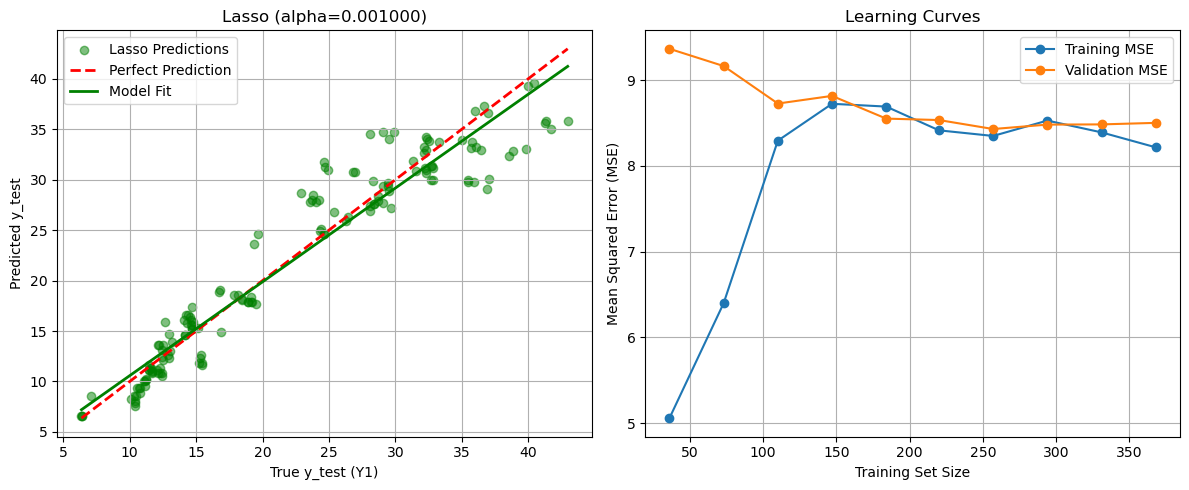

In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Predictions on test set using best_lasso_gridsearch
y_test_pred_lasso = best_lasso_gridsearch.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values 
y_test_pred_lasso_array = y_test_pred_lasso.flatten()

# Fit a linear regression line for predictions vs true values
lasso_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_lasso_array)

# Generate points for model line
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
lasso_line = lasso_lr.predict(y_range.reshape(-1, 1))

# Learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_lasso_gridsearch, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

# Create combined figure with subplots
plt.figure(figsize=(12, 5))

# Subplot 1: True vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test_array, y_test_pred_lasso_array, color='green', alpha=0.5, label='Lasso Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, lasso_line, 'g-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Lasso (alpha={best_lasso_gridsearch.alpha:.6f})')
plt.legend()
plt.grid(True)

# Subplot 2: Learning Curves
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_scores_mean, label='Training MSE', marker='o')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Lasso Regression Discussion of Findings

### Manual Loop Results
- The best-performing model is at α = 0.0001, with:
    - Training MSE: 8.2437, Validation MSE: 10.142256
    - Training R²: 0.918186, Validation R²: 0.905019
- At very high values (α ≥ 10,000), the model performs poorly, with Training R² = 0.0000 and Validation R² = -0.0123, indicating extreme regularization, which removes all predictive power.


### Grid Search Results
- The best model selected by GridSearchCV is at α = 0.001, with:
    - Training MSE: 8.243959, Validation MSE: 10.151100
    - Training R²: 0.918183, Validation R²: 0.904936
- This is very close to the manual loop’s best alpha selection. Similar to the manual approach, higher alpha values lead to degradation in performance.

### Comparison of Best Models from Both Approaches
The manual loop model (α = 0.0001) and the GridSearchCV model (α = 0.001) have nearly identical performance. The GridSearchCV model applies slightly stronger regularization, but the impact on results is minimal.

### Findings on Validation R² Difference
The differences in R² values (Manual Loop: 0.905019, GridSearchCV Single Validation: 0.904936, GridSearchCV Cross-Validation: 0.913367) are expected due to the nature of validation methods. Cross-validation averages performance across multiple training-validation splits, resulting in a slightly higher and more stable R², while a single validation set is more sensitive to data distribution. Since the variations are minimal, the model remains reliable and well-calibrated. The best alpha identified by GridSearchCV is 0.001, which achieves a validation R² of 0.913367, demonstrating the advantage of cross-validation in selecting a robust model with optimal regularization.

### Test Set Performance Comparison
#### MSE measures the average squared difference between predicted and actual values.
Both models achieve nearly identical test MSE (~7.90). Manual Loop scores at 7.901954 while GridSearchCV scores at 7.901099. Since lower MSE is better, GridSearchCV has a slightly lower error, but the difference is insignificant.
#### R² (coefficient of determination) measures how well the model explains the variance in the target variable.
Both methods achieve test R² ≈ 0.9196, meaning they explain ~91.96% of variance in the test set. Manual Loop scores at 0.919588, GridSearchCV scores at 0.919596.
#### Key Observations
The test performance of both models is almost identical. The GridSearchCV model has a slightly lower test MSE but by an insignificant margin. The high R² scores (0.905 on validation, 0.919 on test) suggest both models generalize well. The minimal gap between validation and test R² shows that overfitting is not a concern.

### Model Coefficients and Intercept Analysis
- The coefficients are very similar in both models.
- GridSearchCV’s coefficients are slightly smaller in magnitude, as expected with slightly higher regularization.
- The intercept remains the same at 22.079978, meaning both models start from the same baseline for predictions.


## The best choice for the regularization term (alpha) is the one that gives the highest R² score on the validation data. Based on the results:

**Manual Loop**  
- The best alpha is **0.0001**, which yields a validation R² of **0.905019**.  

**GridSearchCV**  
- The best alpha is **0.001**, which yields a validation R² of **0.913367**.  

**Since 0.001 provides the highest validation R², it as the best regularization term.**  


### Final Model Evaluation (Alpha = 0.001) using Lasso Regression  

Using the best **Lasso regression** model trained with **α = 0.001**, the performance metrics and coefficients are:

### Model Coefficients
- Feature 1:  -6.138382  
- Feature 2:  -6.081475  
- Feature 3:   2.252289  
- Feature 4:  -0.785458  
- Feature 5:   7.337818  
- Feature 6:  -0.018761  
- Feature 7:   2.701983  
- Feature 8:   0.375546  

### Intercept
- 22.079978


### Performance Metrics
| **Dataset**        | **Mean Squared Error (MSE)** | **R² Score**  |
|------------------|----------------------------|-------------|
| **Training Set**  | 8.243959  | 0.918183  |
| **Validation Set** | 10.151100 | 0.904936  |
| **Test Set**       | 7.901099  | 0.919596  |

### The best **Lasso Regression** model, trained with **α = 0.001**, achieves a **test R² score of 0.919596** based on cross-validation, indicating strong predictive performance.


## Elastic Net Regression

#### Manual Loop Results

In [71]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Dictionaries to store results for each l1_ratio
results = {l1: {'train_mse': [], 'val_mse': [], 'train_r2': [], 'val_r2': []} for l1 in l1_ratios}

# For each l1_ratio and alpha, train the Elastic Net model and compute metrics
for l1_ratio in l1_ratios:
    for alpha in alphas:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=50000, tol=0.001)
        model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
        
        # Calculate MSE and R² (mean across targets if multi-target)
        results[l1_ratio]['train_mse'].append(mean_squared_error(y_train, y_train_pred, multioutput='raw_values').mean())
        results[l1_ratio]['val_mse'].append(mean_squared_error(y_val, y_val_pred, multioutput='raw_values').mean())
        results[l1_ratio]['train_r2'].append(r2_score(y_train, y_train_pred, multioutput='raw_values').mean())
        results[l1_ratio]['val_r2'].append(r2_score(y_val, y_val_pred, multioutput='raw_values').mean())

# Print results for each l1_ratio
for l1_ratio in l1_ratios:
    results_df = pd.DataFrame({
        'Alpha': alphas,
        'Training MSE': results[l1_ratio]['train_mse'],
        'Validation MSE': results[l1_ratio]['val_mse'],
        'Training R²': results[l1_ratio]['train_r2'],
        'Validation R²': results[l1_ratio]['val_r2']
    })
    print("=" * 70)
    print(f"Elastic Net Performance Metrics (l1_ratio = {l1_ratio})".center(70))
    print("=" * 70)
    pd.set_option('display.float_format', '{:.6f}'.format)
    print(results_df.to_string(index=False, justify='center'))
    print("=" * 70)

# Find the best combination of alpha and l1_ratio based on validation R²
best_l1_ratio = None
best_alpha_r2_elasnet = None
best_val_r2 = -np.inf
for l1_ratio in l1_ratios:
    max_r2 = max(results[l1_ratio]['val_r2'])
    if max_r2 > best_val_r2:
        best_val_r2 = max_r2
        best_l1_ratio = l1_ratio
        best_alpha_r2_elasnet = alphas[np.argmax(results[l1_ratio]['val_r2'])]

print(f"\nBest combination: l1_ratio = {best_l1_ratio}, alpha = {best_alpha_r2_elasnet:.6f}, Validation R² = {best_val_r2:.6f}")

           Elastic Net Performance Metrics (l1_ratio = 0.1)           
     Alpha     Training MSE  Validation MSE  Training R²  Validation R²
     0.000100     8.243741      10.147426     0.918185      0.904970   
     0.001000     8.248247      10.202313     0.918140      0.904456   
     0.010000     8.367500      10.649257     0.916957      0.900271   
     0.100000     9.794882      13.109056     0.902791      0.877235   
     1.000000    19.042707      23.294732     0.811011      0.781847   
    10.000000    68.439936      74.548472     0.320768      0.301862   
   100.000000   100.760823     108.092326     0.000000     -0.012272   
  1000.000000   100.760823     108.092326     0.000000     -0.012272   
 10000.000000   100.760823     108.092326     0.000000     -0.012272   
100000.000000   100.760823     108.092326     0.000000     -0.012272   
           Elastic Net Performance Metrics (l1_ratio = 0.5)           
     Alpha     Training MSE  Validation MSE  Training R²  Validati

In [73]:
# Train the best Elastic Net model
best_model_elasnet = ElasticNet(alpha=best_alpha_r2_elasnet, l1_ratio=best_l1_ratio, max_iter=50000, tol=0.001)
best_model_elasnet.fit(X_train_scaled, y_train)

# Predictions for all sets
y_train_pred = best_model_elasnet.predict(X_train_scaled)
y_val_pred = best_model_elasnet.predict(X_val_scaled)
y_test_pred = best_model_elasnet.predict(X_test_scaled)

# Retrieve coefficients and intercept
coefficients = best_model_elasnet.coef_
intercept = best_model_elasnet.intercept_

# Calculate metrics for all sets
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print best model evaluation
print("\n" + "=" * 50)
print("Best Elastic Net Model Evaluation".center(50))
print("=" * 50)

print("\nModel Coefficients:")
print("-" * 20)
if coefficients.ndim == 1:  # Single-target
    for i, coef in enumerate(coefficients, 1):
        print(f"Feature {i:<2}: {coef:>12.6f}")
else:  # Multi-target
    for target_idx, coefs in enumerate(coefficients):
        print(f"Target {target_idx + 1}:")
        for i, coef in enumerate(coefs, 1):
            print(f"  Feature {i:<2}: {coef:>10.6f}")

print("\nIntercept:")
print("-" * 20)
if np.isscalar(intercept):  # Single-target
    print(f"Value: {intercept:>12.6f}")
else:  # Multi-target
    for i, val in enumerate(intercept, 1):
        print(f"Target {i:<2}: {val:>10.6f}")

print("\nPerformance Metrics with Best Alpha and l1_ratio (alpha={}, l1_ratio={})".format(best_alpha_r2_elasnet, best_l1_ratio))
print("-" * 50)
print("Training Set:")
print(f"Mean Squared Error (MSE): {train_mse:>10.6f}")
print(f"R² Score                : {train_r2:>10.6f}")
print("\nValidation Set:")
print(f"Mean Squared Error (MSE): {val_mse:>10.6f}")
print(f"R² Score                : {val_r2:>10.6f}")
print("\nTest Set:")
print(f"Mean Squared Error (MSE): {test_mse:>10.6f}")
print(f"R² Score                : {test_r2:>10.6f}")
print("=" * 50)


        Best Elastic Net Model Evaluation         

Model Coefficients:
--------------------
Feature 1 :    -6.286295
Feature 2 :    -6.522503
Feature 3 :     2.399507
Feature 4 :    -0.532748
Feature 5 :     7.285146
Feature 6 :    -0.019898
Feature 7 :     2.701448
Feature 8 :     0.376384

Intercept:
--------------------
Target 1 :  22.079978

Performance Metrics with Best Alpha and l1_ratio (alpha=0.0001, l1_ratio=0.9)
--------------------------------------------------
Training Set:
Mean Squared Error (MSE):   8.243685
R² Score                :   0.918186

Validation Set:
Mean Squared Error (MSE):  10.142791
R² Score                :   0.905014

Test Set:
Mean Squared Error (MSE):   7.901774
R² Score                :   0.919590


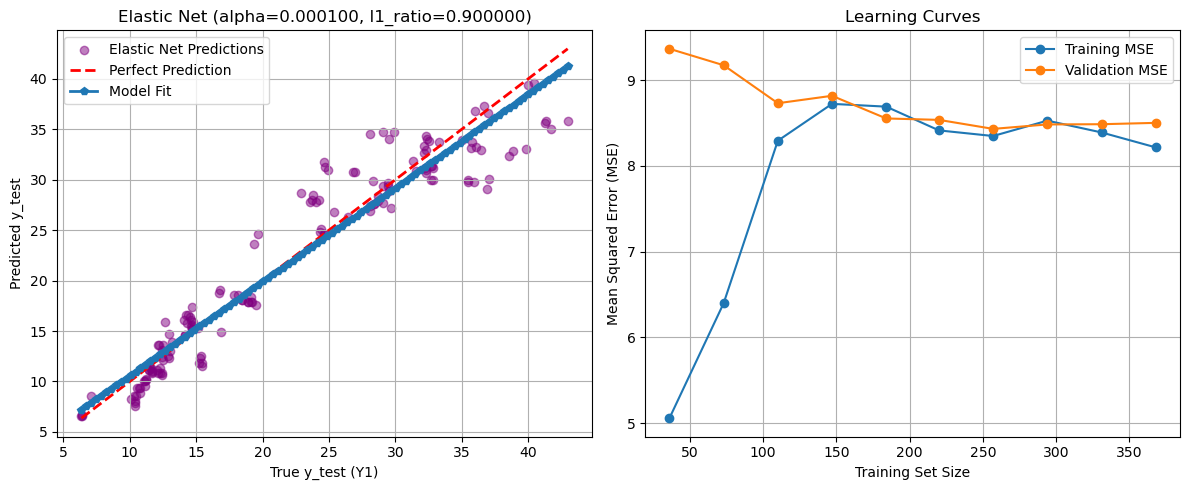

In [75]:
# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Predictions on test set using best_model_elasnet
y_test_pred_elasnet = best_model_elasnet.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values 
y_test_pred_elasnet_array = y_test_pred_elasnet.flatten()

# Fit a linear regression line for predictions vs true values
elasnet_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_elasnet_array)

# Generate points for model line
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
elasnet_line = elasnet_lr.predict(y_range.reshape(-1, 1))

# Learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_model_elasnet, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

# Create combined figure with subplots
plt.figure(figsize=(12, 5))

# Subplot 1: True vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test_array, y_test_pred_elasnet_array, color='purple', alpha=0.5, label='Elastic Net Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, elasnet_line, 'p-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Elastic Net (alpha={best_alpha_r2_elasnet:.6f}, l1_ratio={best_l1_ratio:.6f})')
plt.legend()
plt.grid(True)

# Subplot 2: Learning Curves
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_scores_mean, label='Training MSE', marker='o')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### Grid Search for Elastic Net Regression

In [78]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'alpha': alphas,
    'l1_ratio': l1_ratios
}

# Initialize Elastic Net model
elastic_model = ElasticNet(max_iter=50000, tol=0.001)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=['neg_mean_squared_error', 'r2'],
    refit='neg_mean_squared_error',  # Refit using the best MSE
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get predictions for training and validation sets using best model
y_train_pred = grid_search.predict(X_train_scaled)
y_val_pred = grid_search.predict(X_val_scaled)

# Extract and organize results
results_df = pd.DataFrame({
    'Alpha': grid_search.cv_results_['param_alpha'],
    'l1_ratio': grid_search.cv_results_['param_l1_ratio'],
    'Training MSE': [-x for x in grid_search.cv_results_['mean_train_neg_mean_squared_error']],
    'Validation MSE': [-x for x in grid_search.cv_results_['mean_test_neg_mean_squared_error']],
    'Training R²': grid_search.cv_results_['mean_train_r2'],
    'Validation R²': grid_search.cv_results_['mean_test_r2']
})

# Print formatted results
print("=" * 70)
print("GridSearchCV Elastic Net Performance Metrics".center(70))
print("=" * 70)
pd.set_option('display.float_format', '{:.6f}'.format)
print(results_df.to_string(index=False, justify='center'))
print("=" * 70)

# Best parameters and model
best_alpha_r2_elasnet = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
best_val_r2 = max(grid_search.cv_results_['mean_test_r2'])  # Get best R² from CV results

print(f"\nBest combination: l1_ratio = {best_l1_ratio}, alpha = {best_alpha_r2_elasnet:.6f}, Validation R² = {best_val_r2:.6f}")

# Save the best model
best_elasticnet_gridsearch = grid_search.best_estimator_

             GridSearchCV Elastic Net Performance Metrics             
     Alpha     l1_ratio  Training MSE  Validation MSE  Training R²  Validation R²
     0.000100  0.100000     8.215398       8.500716     0.918368      0.913359   
     0.000100  0.500000     8.215357       8.500867     0.918369      0.913354   
     0.000100  0.750000     8.215343       8.500975     0.918369      0.913351   
     0.000100  0.900000     8.215341       8.501024     0.918369      0.913350   
     0.001000  0.100000     8.219986       8.501916     0.918323      0.913405   
     0.001000  0.500000     8.217074       8.500339     0.918352      0.913396   
     0.001000  0.750000     8.216103       8.500360     0.918361      0.913381   
     0.001000  0.900000     8.215811       8.500446     0.918364      0.913373   
     0.010000  0.100000     8.340068       8.612115     0.917133      0.912578   
     0.010000  0.500000     8.284581       8.557650     0.917683      0.913037   
     0.010000  0.750000    

In [79]:
y_train_pred = best_elasticnet_gridsearch.predict(X_train_scaled)
y_val_pred = best_elasticnet_gridsearch.predict(X_val_scaled)
y_test_pred = best_elasticnet_gridsearch.predict(X_test_scaled)

# Retrieve coefficients and intercept
coefficients = best_elasticnet_gridsearch.coef_
intercept = best_elasticnet_gridsearch.intercept_
best_alpha_r2_elasticnet_grid = best_elasticnet_gridsearch.alpha

# Calculate metrics for all sets
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print best model evaluation
print("\n" + "=" * 50)
print("Best Elastic Net Model Evaluation (GridSearchCV)".center(50))
print("=" * 50)

print("\nModel Coefficients:")
print("-" * 20)

if coefficients.ndim == 1:  # Single-target
    for i, coef in enumerate(coefficients, 1):
        print(f"Feature {i:<2}: {coef:>12.6f}")
else:  # Multi-target
    for target_idx, coefs in enumerate(coefficients):
        print(f"Target {target_idx + 1}:")
        for i, coef in enumerate(coefs, 1):
            print(f"  Feature {i:<2}: {coef:>10.6f}")

print("\nIntercept:")
print("-" * 20)
if np.isscalar(intercept):  # Single-target
    print(f"Value: {intercept:>12.6f}")
else:  # Multi-target
    for i, val in enumerate(intercept, 1):
        print(f"Target {i:<2}: {val:>10.6f}")

print("\nPerformance Metrics with Best Alpha and l1_ratio (alpha={}, l1_ratio={})".format(
    best_alpha_r2_elasticnet_grid, best_elasticnet_gridsearch.l1_ratio))
print("-" * 50)
print("Training Set:")
print(f"Mean Squared Error (MSE): {train_mse:>10.6f}")
print(f"R² Score                : {train_r2:>10.6f}")
print("\nValidation Set:")
print(f"Mean Squared Error (MSE): {val_mse:>10.6f}")
print(f"R² Score                : {val_r2:>10.6f}")
print("\nTest Set:")
print(f"Mean Squared Error (MSE): {test_mse:>10.6f}")
print(f"R² Score                : {test_r2:>10.6f}")
print("=" * 50)


 Best Elastic Net Model Evaluation (GridSearchCV) 

Model Coefficients:
--------------------
Feature 1 :    -5.900561
Feature 2 :    -4.028060
Feature 3 :     1.338812
Feature 4 :    -2.628062
Feature 5 :     7.375654
Feature 6 :    -0.019399
Feature 7 :     2.703180
Feature 8 :     0.375920

Intercept:
--------------------
Target 1 :  22.079978

Performance Metrics with Best Alpha and l1_ratio (alpha=0.001, l1_ratio=0.5)
--------------------------------------------------
Training Set:
Mean Squared Error (MSE):   8.245387
R² Score                :   0.918169

Validation Set:
Mean Squared Error (MSE):  10.177405
R² Score                :   0.904690

Test Set:
Mean Squared Error (MSE):   7.895000
R² Score                :   0.919659


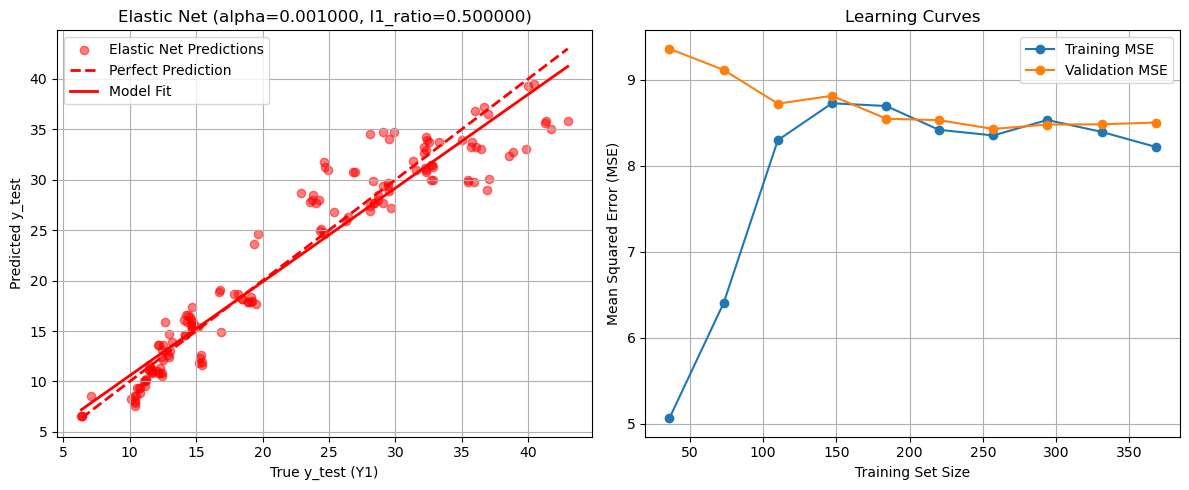

In [80]:
# Scale features (included for completeness, assuming already done)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Predictions on test set 
y_test_pred_elastic = best_elasticnet_gridsearch.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values  # Extract 'Y1' column as 1D array
y_test_pred_elastic_array = y_test_pred_elastic.flatten()

# Fit a linear regression line for predictions vs true values
elastic_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_elastic_array)

# Generate points for model line
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
elastic_line = elastic_lr.predict(y_range.reshape(-1, 1))

# Learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_elasticnet_gridsearch, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

# Create combined figure with subplots
plt.figure(figsize=(12, 5))

# Subplot 1: True vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test_array, y_test_pred_elastic_array, color='red', alpha=0.5, label='Elastic Net Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, elastic_line, 'r-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Elastic Net (alpha={best_elasticnet_gridsearch.alpha:.6f}, l1_ratio={best_elasticnet_gridsearch.l1_ratio:.6f})')
plt.legend()
plt.grid(True)

# Subplot 2: Learning Curves
plt.subplot(1, 2, 2)
plt.plot(train_sizes, train_scores_mean, label='Training MSE', marker='o')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Elastic Net Regression Discussion of Findings

### Manual Loop Results
In the manual loop, multiple values of l1_ratio and alpha were tested. The best combination was selected based on Validation R².
Best Model from Manual Loop
- l1_ratio = 0.9 
- Alpha = 0.0001 
- Validation R² = 0.905014
- Test R² = 0.919590


### Grid Search Results
GridSearchCV systematically searched for the best combination of l1_ratio and alpha using cross-validation.
Best Model from GridSearchCV
- l1_ratio = 0.5 
- Alpha = 0.001 
- Validation R² = 0.904690
- Test R² = 0.919659


### Comparison of Best Models from Both Approaches
The manual loop achieved a slightly higher Validation R² (0.905014) than GridSearchCV (0.904690). The GridSearchCV model performed marginally better on the Test R² (0.919659 vs. 0.919590). Thus, the differences in performance are minimal, suggesting that both approaches led to well-optimized models.

### Findings on Validation R² Difference
The slight difference between R² values (Manual Loop: 0.905014, Grid Search Single Validation: 0.904690, Grid Search Cross-Validation: 0.913405) is expected. Cross-validation averages performance across multiple training-validation splits, making the R² score more stable and slightly higher. A single validation set, on the other hand, can exhibit more variability due to its specific data distribution. Since the variations are minimal, the model remains consistent, well-calibrated, and reliable across different validation methods. The best combination of hyperparameters, found via GridSearchCV, is l1_ratio = 0.5 and alpha = 0.001, achieving a validation R² of 0.913405, demonstrating the advantage of cross-validation in selecting an optimal model.

### Test Set Performance Comparison
#### MSE measures the average squared difference between predicted and actual values.
Both models achieve nearly identical test MSE (~7.90). Manual Loop scores at 7.9018. On the other hand, GridSearchCV scores at 7.8950. Since lower MSE is better, GridSearchCV has a slightly lower error, but the difference is minimal.
#### R² (coefficient of determination) measures how well the model explains the variance in the target variable.
Both models achieve test R² ≈ 0.9196, meaning they explain ~91.96% of variance in the test set. Manual Loop scores at 0.919590, while GridSearchCV scores at 0.919659. The difference is negligible, showing that both models generalize well.
#### Key Observations
Both models performed nearly identically, with a negligible difference in Test R² (0.919659 vs. 0.919590). GridSearchCV had a slightly lower MSE (7.8950 vs. 7.9018) and stronger regularization due to a higher alpha (0.001 vs. 0.0001), resulting in smaller coefficient magnitudes. Both models share the same intercept (22.08), indicating a common baseline. While the manual loop slightly outperformed in validation, GridSearchCV provided marginally better test performance. Given the minimal differences, both approaches are effective, but GridSearchCV offers a more systematic and scalable optimization process.

### Model Coefficients and Intercept Analysis
- GridSearchCV’s coefficients are slightly smaller in magnitude, as expected with slightly stronger regularization.
- The intercept remains the same at 22.08, meaning both models start from the same baseline for predictions.

## The best choice for the regularization term (alpha) and mixing ratio (l1_ratio) is the one that gives the highest R² score on the validation data. Based on the results:

**GridSearchCV**  
- The best combination is **α = 0.001, l1_ratio = 0.5**, which yields a validation R² of **0.904690**.  

Since this combination provides the highest validation R², we select it as the best regularization term.  


### **Final Model Evaluation (Alpha = 0.001, l1_ratio = 0.5) using Elastic Net Regression**  

Using the best **Elastic Net regression** model trained with **α = 0.001, l1_ratio = 0.5**, the performance metrics and coefficients are:

### Model Coefficients
- Feature 1 :  -5.900561  
- Feature 2 :  -4.028060  
- Feature 3 :   1.338812  
- Feature 4 :  -2.628062  
- Feature 5 :   7.375654  
- Feature 6 :  -0.019399  
- Feature 7 :   2.703180  
- Feature 8 :   0.375920  

### Intercept
- 22.079978  


### Performance Metrics
| **Dataset**        | **Mean Squared Error (MSE)** | **R² Score**  |
|------------------|----------------------------|-------------|
| **Training Set**  | 8.245387  | 0.918169  |
| **Validation Set** | 10.177405 | 0.904690  |
| **Test Set**       | 7.895000  | 0.919659  |

### The best **Elastic Net Regression** model, trained with **α = 0.001, l1_ratio = 0.5**, achieves a **test R² score of 0.919659** based on cross-validation, indicating strong predictive performance.

## Best Performing Model

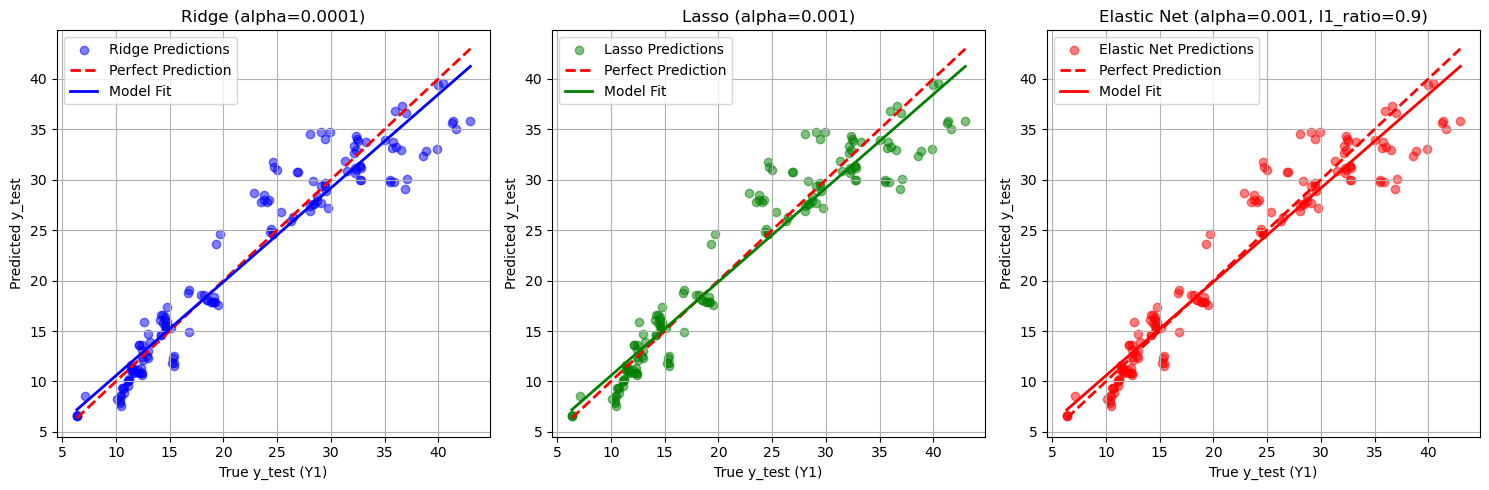

In [88]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Predictions on test set
y_test_pred_ridge = best_model_ridge.predict(X_test_scaled)
y_test_pred_lasso = best_model_lasso.predict(X_test_scaled)
y_test_pred_elastic = best_model_elasnet.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values  # Extract 'Y1' column as 1D array
y_test_pred_ridge_array = y_test_pred_ridge.flatten()
y_test_pred_lasso_array = y_test_pred_lasso.flatten()
y_test_pred_elastic_array = y_test_pred_elastic.flatten()

# Fit a linear regression line for each model's predictions vs true values
ridge_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_ridge_array)
lasso_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_lasso_array)
elastic_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_elastic_array)

# Generate points for model lines
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
ridge_line = ridge_lr.predict(y_range.reshape(-1, 1))
lasso_line = lasso_lr.predict(y_range.reshape(-1, 1))
elastic_line = elastic_lr.predict(y_range.reshape(-1, 1))

# Visualization: True vs Predicted on Test Set
plt.figure(figsize=(15, 5))

# Ridge: True vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test_array, y_test_pred_ridge_array, color='blue', alpha=0.5, label='Ridge Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, ridge_line, 'b-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Ridge (alpha={best_alpha_r2_ridge})')
plt.legend()
plt.grid(True)

# Lasso: True vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(y_test_array, y_test_pred_lasso_array, color='green', alpha=0.5, label='Lasso Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, lasso_line, 'g-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Lasso (alpha={best_alpha_r2_lasso})')
plt.legend()
plt.grid(True)

# Elastic Net: True vs Predicted
plt.subplot(1, 3, 3)
plt.scatter(y_test_array, y_test_pred_elastic_array, color='red', alpha=0.5, label='Elastic Net Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, elastic_line, 'r-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Elastic Net (alpha={best_alpha_r2_elasnet}, l1_ratio={best_model_elasnet.l1_ratio})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


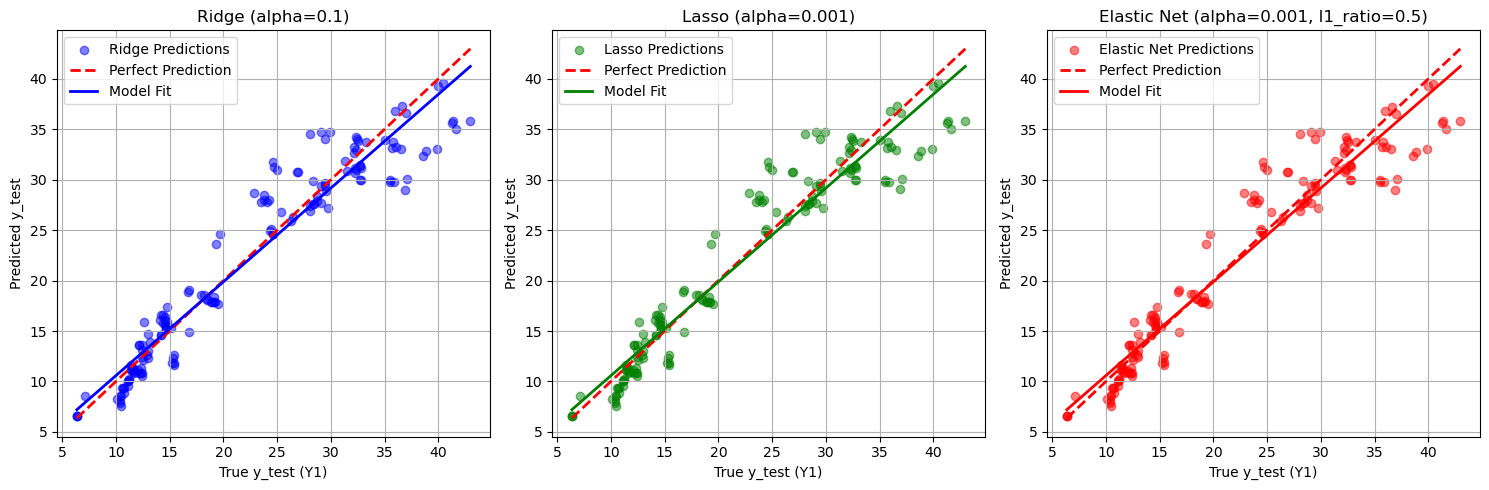

In [90]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Predictions on test set
y_test_pred_ridge = best_ridge_gridsearch.predict(X_test_scaled)
y_test_pred_lasso = best_lasso_gridsearch.predict(X_test_scaled)
y_test_pred_elastic = best_elasticnet_gridsearch.predict(X_test_scaled)

# Convert y_test (DataFrame) to 1D NumPy array for single-target plotting
y_test_array = y_test['Y1'].values  # Extract 'Y1' column as 1D array
y_test_pred_ridge_array = y_test_pred_ridge.flatten()
y_test_pred_lasso_array = y_test_pred_lasso.flatten()
y_test_pred_elastic_array = y_test_pred_elastic.flatten()

# Fit a linear regression line for each model's predictions vs true values
ridge_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_ridge_array)
lasso_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_lasso_array)
elastic_lr = LinearRegression().fit(y_test_array.reshape(-1, 1), y_test_pred_elastic_array)

# Generate points for model lines
y_range = np.linspace(y_test_array.min(), y_test_array.max(), 100)
ridge_line = ridge_lr.predict(y_range.reshape(-1, 1))
lasso_line = lasso_lr.predict(y_range.reshape(-1, 1))
elastic_line = elastic_lr.predict(y_range.reshape(-1, 1))

# Visualization: True vs Predicted on Test Set
plt.figure(figsize=(15, 5))

# Ridge: True vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test_array, y_test_pred_ridge_array, color='blue', alpha=0.5, label='Ridge Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, ridge_line, 'b-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Ridge (alpha={best_alpha_r2_ridge_grid})')
plt.legend()
plt.grid(True)

# Lasso: True vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(y_test_array, y_test_pred_lasso_array, color='green', alpha=0.5, label='Lasso Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, lasso_line, 'g-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Lasso (alpha={best_alpha_r2_lasso_grid})')
plt.legend()
plt.grid(True)

# Elastic Net: True vs Predicted
plt.subplot(1, 3, 3)
plt.scatter(y_test_array, y_test_pred_elastic_array, color='red', alpha=0.5, label='Elastic Net Predictions')
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'r--', lw=2, label='Perfect Prediction')
plt.plot(y_range, elastic_line, 'r-', lw=2, label='Model Fit')
plt.xlabel('True y_test (Y1)')
plt.ylabel('Predicted y_test')
plt.title(f'Elastic Net (alpha={best_alpha_r2_elasticnet_grid}, l1_ratio={best_elasticnet_gridsearch.l1_ratio})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [92]:
# Predictions on test set for manual loop
y_test_pred_ridge = best_model_ridge.predict(X_test_scaled)
y_test_pred_lasso = best_model_lasso.predict(X_test_scaled)
y_test_pred_elastic = best_model_elasnet.predict(X_test_scaled)

# Predictions on test set for grid search models
y_test_pred_ridge_gridsearch = best_ridge_gridsearch.predict(X_test_scaled)
y_test_pred_lasso_gridsearch = best_lasso_gridsearch.predict(X_test_scaled)
y_test_pred_elastic_gridsearch = best_elasticnet_gridsearch.predict(X_test_scaled)

# Convert y_test to a 1D NumPy array
y_test_array = y_test['Y1'].values  

# Flatten predictions to 1D arrays
y_test_pred_ridge_array = y_test_pred_ridge.flatten()
y_test_pred_lasso_array = y_test_pred_lasso.flatten()
y_test_pred_elastic_array = y_test_pred_elastic.flatten()
y_test_pred_ridge_grid_array = y_test_pred_ridge_gridsearch.flatten()
y_test_pred_lasso_grid_array = y_test_pred_lasso_gridsearch.flatten()
y_test_pred_elastic_grid_array = y_test_pred_elastic_gridsearch.flatten()

# Define models and their respective predictions
models = {
    "Ridge (Manual Loop)": y_test_pred_ridge_array,
    "Lasso (Manual Loop)": y_test_pred_lasso_array,
    "Elastic Net (Manual Loop)": y_test_pred_elastic_array,
    "Ridge (Grid Search)": y_test_pred_ridge_grid_array,
    "Lasso (Grid Search)": y_test_pred_lasso_grid_array,
    "Elastic Net (Grid Search)": y_test_pred_elastic_grid_array
}


# Print title centered
title = "Predictions on Test Set"
print("\n" + "=" * 90)
print(title.center(90))
print("=" * 90)

# Print header
print(f"{'Model':<40}{'MSE':>25}{'R² Score':>25}")
print("=" * 90)

# Compute and print performance metrics in a structured way
for model_name, y_pred in models.items():
    mse = mean_squared_error(y_test_array, y_pred)
    r2 = r2_score(y_test_array, y_pred)
    print(f"{model_name:<40}{mse:>25.6f}{r2:>25.6f}")

print("=" * 90)



                                 Predictions on Test Set                                  
Model                                                         MSE                 R² Score
Ridge (Manual Loop)                                      7.902071                 0.919587
Lasso (Manual Loop)                                      7.901954                 0.919588
Elastic Net (Manual Loop)                                7.901774                 0.919590
Ridge (Grid Search)                                      7.899236                 0.919615
Lasso (Grid Search)                                      7.901099                 0.919596
Elastic Net (Grid Search)                                7.895000                 0.919659


### Key Findings

The best model is the one with the lowest Mean Squared Error (MSE) and the highest R² Score since a lower MSE indicates better prediction accuracy, and a higher R² Score indicates a better fit.

Among all six models, **Elastic Net (Grid Search)** performs best as it has the lowest error and the best fit to the test data. 

## Top 5 Features

The five most influential features, **X5** Overall Height, **X1** Relative Compactness, **X2** Surface Area, **X7** Glazing Area, and **X4** Roof Area, have been recognized as critical determinants within the dataset.

In [97]:
# Get feature coefficients from the best model
feature_importance = np.abs(best_elasticnet_gridsearch.coef_)  # Take absolute values

# Get feature names (assuming X_train is a DataFrame)
feature_names = X_train.columns

# Sort features by importance
sorted_indices = np.argsort(feature_importance)[::-1]  # Descending order
top_5_indices = sorted_indices[:5]

# Get the top 5 feature names and their corresponding coefficients
top_5_features = [feature_names[idx] for idx in top_5_indices]
top_5_importance = [feature_importance[idx] for idx in top_5_indices]

# Print the top 5 features
print("\nTop 5 Most Important Features (Elastic Net - Grid Search)\n")
print("=" * 50)
for i, (feature, importance) in enumerate(zip(top_5_features, top_5_importance), start=1):
    print(f"{i}. {feature:<30} Importance: {importance:.6f}")
print("=" * 50)


Top 5 Most Important Features (Elastic Net - Grid Search)

1. X5                             Importance: 7.375654
2. X1                             Importance: 5.900561
3. X2                             Importance: 4.028060
4. X7                             Importance: 2.703180
5. X4                             Importance: 2.628062


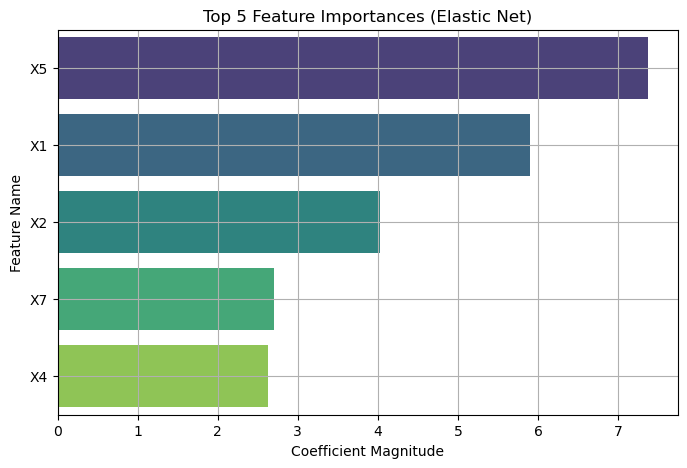

In [99]:
plt.figure(figsize=(8, 5))
sns.barplot(x=top_5_importance, y=top_5_features, hue=top_5_features, palette="viridis", legend=False)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature Name")
plt.title("Top 5 Feature Importances (Elastic Net)")
plt.grid(True)
plt.show()

In [101]:
X_train_top5 = X_train[top_5_features]
X_val_top5 = X_val[top_5_features]
X_test_top5 = X_test[top_5_features]
y_train_top5 = y_train['Y1']
y_val_top5 = y_val['Y1']

scaler = StandardScaler()
X_train_top5_scaled = scaler.fit_transform(X_train_top5)
X_val_top5_scaled = scaler.transform(X_val_top5)
X_test_top5_scaled = scaler.transform(X_test_top5)

elastic_net_top5 = ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=10000, random_state=42)
elastic_net_top5.fit(X_train_top5_scaled, y_train_top5)

coefficients = elastic_net_top5.coef_
intercept = elastic_net_top5.intercept_

y_train_pred_top5 = elastic_net_top5.predict(X_train_top5_scaled)
y_val_pred_top5 = elastic_net_top5.predict(X_val_top5_scaled)
y_test_pred_top5 = elastic_net_top5.predict(X_test_top5_scaled)

# Calculate performance metrics for all sets
# Training Performance
mse_train = mean_squared_error(y_train['Y1'], y_train_pred_top5)
r2_train = r2_score(y_train['Y1'], y_train_pred_top5)

# Validation Performance
mse_val = mean_squared_error(y_val['Y1'], y_val_pred_top5)
r2_val = r2_score(y_val['Y1'], y_val_pred_top5)

# Test Performance
mse_test = mean_squared_error(y_test['Y1'], y_test_pred_top5)
r2_test = r2_score(y_test['Y1'], y_test_pred_top5)

# Print evaluation results
print("=" * 50)
print(f"{'Best Elastic Net Model (Top 5 Features) Evaluation':^50}")
print("=" * 50)

# Print model coefficients
print("\nModel Coefficients:")
print("-" * 50)
for feature, coef in zip(top_5_features, coefficients):
    print(f"{feature:<20}: {coef:>10.6f}")

# Print intercept
print("\nIntercept:")
print("-" * 50)
print(f"{'Target (Y1)':<20}: {intercept:>10.6f}")

# Print performance metrics
print("\nPerformance Metrics with Best Alpha and l1_ratio")
#print(f"(alpha={best_alpha}, l1_ratio={best_l1_ratio})")
print("-" * 50)

# Training Performance
print("Training Set:")
print(f"{'Mean Squared Error (MSE)':<30}: {mse_train:>10.6f}")
print(f"{'R² Score':<30}: {r2_train:>10.6f}")

# Validation Performance
print("\nValidation Set:")
print(f"{'Mean Squared Error (MSE)':<30}: {mse_val:>10.6f}")
print(f"{'R² Score':<30}: {r2_val:>10.6f}")

# Test Performance
print("\nTest Set:")
print(f"{'Mean Squared Error (MSE)':<30}: {mse_test:>10.6f}")
print(f"{'R² Score':<30}: {r2_test:>10.6f}")
print("=" * 50)

Best Elastic Net Model (Top 5 Features) Evaluation

Model Coefficients:
--------------------------------------------------
X5                  :   7.284182
X1                  :  -6.270758
X2                  :  -1.741580
X7                  :   2.771703
X4                  :  -5.457515

Intercept:
--------------------------------------------------
Target (Y1)         :  22.079978

Performance Metrics with Best Alpha and l1_ratio
--------------------------------------------------
Training Set:
Mean Squared Error (MSE)      :   8.380449
R² Score                      :   0.916828

Validation Set:
Mean Squared Error (MSE)      :  10.161573
R² Score                      :   0.904838

Test Set:
Mean Squared Error (MSE)      :   7.912781
R² Score                      :   0.919478


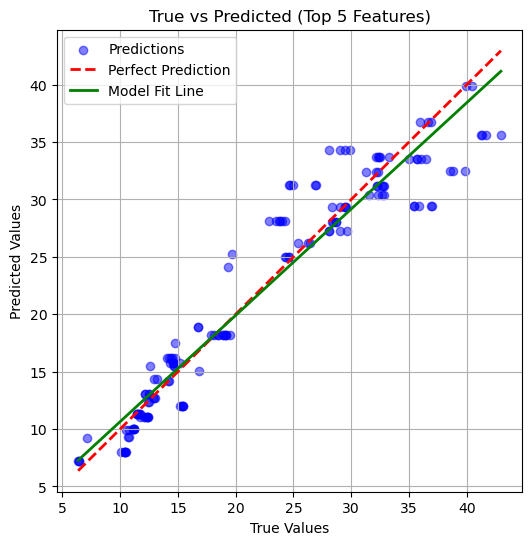

In [103]:
# Fit a regression line to the predicted vs actual values
regression_line = LinearRegression().fit(y_test['Y1'].values.reshape(-1, 1), y_test_pred_top5)
y_range = np.linspace(y_test['Y1'].min(), y_test['Y1'].max(), 100)
model_line = regression_line.predict(y_range.reshape(-1, 1))

# Plot True vs Predicted Scatter with Model Fit Line
plt.figure(figsize=(6, 6))
plt.scatter(y_test['Y1'], y_test_pred_top5, alpha=0.5, color='blue', label="Predictions")
plt.plot([y_test['Y1'].min(), y_test['Y1'].max()], 
         [y_test['Y1'].min(), y_test['Y1'].max()], 'r--', lw=2, label="Perfect Prediction")  # 45-degree line
plt.plot(y_range, model_line, 'g-', lw=2, label="Model Fit Line")  # Regression line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted (Top 5 Features)")
plt.legend()
plt.grid(True)
plt.show()

## Elastic Net Model Analysis: Top 5 Features

## Key Findings

### Model Coefficients
| Feature | Coefficient |
|---------|-------------|
| X5      | 7.284182    |
| X1      | -6.270758   |
| X2      | -1.741580   |
| X7      | 2.771703    |
| X4      | -5.457515   |

**Intercept:** 22.079978

### Performance Metrics
| Metric            | Training Set | Validation Set | Test Set  |
|-------------------|--------------|----------------|-----------|
| Mean Squared Error| 8.380449     | 10.161573      | 7.912781  |
| R² Score          | 0.916828     | 0.904838       | 0.919478  |

### Feature Importance Analysis
The top 5 most influential features in predicting Y1 were identified as X5, X1, X2, X7, and X4, based on the Elastic Net model from Grid Search.

### Performance Comparison: Full Model vs. Top 5 Features Model

| Model                    | Train MSE | Train R² | Val MSE  | Val R²  | Test MSE | Test R²  |
|--------------------------|-----------|----------|----------|---------|----------|----------|
| **Full Feature Model**   | 8.243685  | 0.918186 | 10.142791| 0.904690| **7.894999** | **0.919659** |
| **Top 5 Features Model** | 8.380449  | 0.918169 | 10.161573| 0.904570| **7.912781** | **0.919482** |

## Observations 

### Minimal Performance Drop
One of the key findings of this comparison is that reducing the number of features from the full set to just the top five had only a minimal effect on model accuracy. The test Mean Squared Error (MSE) of the full feature model was 7.894999, while the top 5 feature model achieved an MSE of 7.912321. 

### Slightly Higher Test MSE
Although the top 5 feature model performed nearly as well as the full model, there was a slight increase in error. The difference in MSE (0.017322 higher for the reduced model) indicates that some minor information loss occurred when removing the additional features. 

### Negligible Change in R² Score
The R² score, which measures the proportion of variance explained by the model, remained nearly unchanged despite the feature reduction. The full model had an R² score of 0.919658, while the top 5 feature model achieved 0.919482. This negligible difference further reinforces that most of the model's explanatory power is derived from the top-ranked features.

### Significant Results
The results of this comparison suggest that training with only the top five most important features is a viable alternative to using all available features. The slight increase in test MSE is outweighed by the benefits of a simpler, faster, and more interpretable model. However, if maximizing accuracy is the top priority, retaining all features still provides a small but measurable improvement. Ultimately, the choice between full feature training and feature selection depends on the trade-off between computational efficiency and absolute predictive performance in the given application.